# Intro to Bioinformatics Applications of R

<div class="alert alert-block alert-info">
    
Let's practice using R to analyze some data using data manipulation and visualizations. We will use publicly-available data ([GSE166925](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE166925)) from NCBI GEO with inflammatory bowel disease and colorectal cancer patients.
 
<br><br> 
RNA-seq data usually comes with two files: 
<ul>
<li> a metadata file with information about the samples (ex: sample ID, disease status, gender, etc.) where each row represents a sample and columns contain the various information </li>
<li> a gene expression file with the gene expression information for each sample where the rows represent the genes and the columns represent the samples </li>
</ul>
</div>

First, let's get the metadata using the [`GEOquery`](https://bioconductor.org/packages/devel/bioc/vignettes/GEOquery/inst/doc/GEOquery.html) library.

### Libraries
Every time you load a library you're adding a new environment to R. The library specific functions become available because R searches all environments for your function call. Sometimes you override an existing function by loading a new library. You can reference the package-specific function via the package specifier.

Note: You can also suppress the messages printed when loading a library using [`suppressPackageStartupMessages()`](https://www.geeksforgeeks.org/how-to-disable-messages-when-loading-a-package-in-r/). 

One of the benefits of using libraries is you don't need to rewrite code that already exists! We can use the `getGEO()` function from the `GEOquery` library to automatically get the data from GEO instead of manually trying to get the sample information.

The code is provided here, but we won't run it:

    # Get data
    suppressPackageStartupMessages(library(GEOquery))
    
    #Sys.setenv(VROOM_CONNECTION_SIZE=500072) # Might need to change to have enough buffer to download  file
    gse <- getGEO(GEO='GSE166925',destdir='data/')

Using the gse object we created, we can get the sample information/metadata and store it in a `meta` dataframe we can later refer to.

    # Generate data frame for metadata
    gse_data <- gse[[1]]
    
    columns <- c("title","disease:ch1","gender:ch1", "inflammation_status:ch1", "nancy_score:ch1",
                    "patient_age:ch1","site_taken:ch1")
    
    meta <- pData(gse_data)[, which((names(pData(gse_data)) %in% columns)==TRUE)]

    # Save metadata table to file for later use
    write.table(meta, "data/GSE166925-meta.tsv", sep='\t',quote=FALSE)

The metadata file is located here: `data/GSE166925-meta.tsv`
<br><br>

Now we need the gene expression file. This is available for download on the GSE166925 NCBI GEO page under Supplementary file. To get this file, you can either click on the http link to locally download it, or use the ftp link to download it on the server. 

The terminal command to get the data is : 

`wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166925/suppl/GSE166925_salmon.genes.tpms.txt.gz`

This file was already downloaded onto DataHub and is available here: 

`~/public/module-1-programming/data/GSE166925_salmon.genes.tpms.txt.gz`

<div class="alert alert-block alert-success">

<p>We now have both the metadata and gene expression files ready to analyze.</p>

</div>

### Data Manipulation
We need to format the data in a way that we can use for later analyses/visualizations.

Let's read in the sample metadata table that was saved to GSE166925-meta.tsv (file location: `~/module-1-programming/data/GSE166925-meta.tsv`) into a `meta` dataframe object. We can use the [`read.table()`](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/read.table) function to generate dataframes from files.

In [1]:
meta <- read.table('data/GSE166925-meta.tsv',sep='\t')
head(meta)

,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
GSM5088383,UC_I_LI_M_1,UC,male,inflamed,2,56,large_intestine
GSM5088385,UC_NA_LI_F_2,UC,female,inflamed,4,63,large_intestine
GSM5088387,CD_I_SI_F_3,CD,female,inflamed,4,56,small_intestine
GSM5088389,CD_I_SI_M_4,CD,male,inflamed,NA,33,small_intestine
GSM5088391,CD_I_LI_M_5,CD,male,inflamed,2,28,large_intestine
GSM5088392,CD_U_LI_M_6,CD,male,uninflamed,NA,55,large_intestine


Let's also use the title column as the index instead of the GSM IDs using `rownames()`.

In [2]:
rownames(meta) <- meta$title
head(meta)

,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
UC_I_LI_M_1,UC_I_LI_M_1,UC,male,inflamed,2,56,large_intestine
UC_NA_LI_F_2,UC_NA_LI_F_2,UC,female,inflamed,4,63,large_intestine
CD_I_SI_F_3,CD_I_SI_F_3,CD,female,inflamed,4,56,small_intestine
CD_I_SI_M_4,CD_I_SI_M_4,CD,male,inflamed,NA,33,small_intestine
CD_I_LI_M_5,CD_I_LI_M_5,CD,male,inflamed,2,28,large_intestine
CD_U_LI_M_6,CD_U_LI_M_6,CD,male,uninflamed,NA,55,large_intestine


Now let's read in the gene expression data table from the file GSE166925_salmon.genes.tpms.txt.gz into an `expr` dataframe. (file location: `~/public/module-1-programming/data/GSE166925_salmon.genes.tpms.txt.gz`)

In [3]:
expr <- read.table('~/public/module-1-programming/data/GSE166925_salmon.genes.tpms.txt.gz',sep='\t',header=TRUE)
head(expr)

,gene_id,CD_I_LI_F_22,CD_I_LI_F_29,CD_I_LI_M_15,CD_I_LI_M_24,CD_I_LI_M_36,CD_I_LI_M_49,CD_I_LI_M_5,CD_I_SI_F_20,CD_I_SI_F_25,⋯,UC_I_LI_F_45,UC_I_LI_F_8,UC_I_LI_M_1,UC_I_LI_M_34,UC_I_LI_M_9,UC_M_LI_F_18,UC_NA_LI_F_2,UC_U_LI_F_40,UC_U_LI_M_33,UC_U_SI_F_17
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,5.094850,2.955470,1.848870,3.802330,10.161400,3.467200,5.025920,8.968070,3.502050,⋯,1.903170,3.108230,3.445030,3.172990,4.513300,3.855490,5.914390,5.358530,10.344300,5.411630
2,ENSG00000000005,0.433639,0.205504,0.000000,0.000000,0.604877,0.000000,0.120606,0.250889,0.000000,⋯,0.037813,0.166965,0.000000,0.626974,0.060215,0.202251,0.000000,0.259292,0.091125,0.045819
3,ENSG00000000419,4.234940,3.350510,2.427460,2.880860,2.305760,7.085010,3.347020,5.985330,3.147280,⋯,4.002100,5.209190,2.981830,4.407800,5.677800,4.117850,4.468820,4.909960,5.736400,3.649040
4,ENSG00000000457,0.586098,0.425931,0.501005,0.411644,0.529764,0.400366,0.651770,0.747979,0.301862,⋯,0.369654,0.671137,0.362387,1.007640,0.855920,0.138235,0.219709,0.722102,0.330994,0.276997
5,ENSG00000000460,0.344564,0.579495,0.483984,0.258893,0.122450,0.000000,0.495650,0.146662,0.000000,⋯,0.204045,0.344391,0.624086,0.399062,0.319007,0.126902,0.287883,0.300087,0.136381,0.280994
6,ENSG00000000938,6.478880,3.278080,8.245220,12.607800,1.262730,11.969700,2.134260,2.014500,1.779640,⋯,10.377400,9.366620,7.472590,12.876000,8.059280,1.073340,7.508690,4.989870,2.754170,1.312720


We'll review this more in the RNA-seq module but when looking at gene expression data, we usually use the log normalized expression for analysis. The file provided already has normalized data (TPM in given in the filename), so we can take the log using `apply()`.

In [4]:
expr[-1] <- apply(expr[-1], 2, log1p)
head(expr)

,gene_id,CD_I_LI_F_22,CD_I_LI_F_29,CD_I_LI_M_15,CD_I_LI_M_24,CD_I_LI_M_36,CD_I_LI_M_49,CD_I_LI_M_5,CD_I_SI_F_20,CD_I_SI_F_25,⋯,UC_I_LI_F_45,UC_I_LI_F_8,UC_I_LI_M_1,UC_I_LI_M_34,UC_I_LI_M_9,UC_M_LI_F_18,UC_NA_LI_F_2,UC_U_LI_F_40,UC_U_LI_M_33,UC_U_SI_F_17
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,1.8074442,1.3750994,1.0469224,1.5691012,2.4124614,1.4967618,1.7960702,2.2993870,1.5045328,⋯,1.06580324,1.4129923,1.4917866,1.4286328,1.70716335,1.5801100,1.9336047,1.8497972,2.42871542,1.85811353
2,ENSG00000000005,0.3602160,0.1868977,0.0000000,0.0000000,0.4730471,0.0000000,0.1138696,0.2238545,0.0000000,⋯,0.03711561,0.1544064,0.0000000,0.4867218,0.05847172,0.1841956,0.0000000,0.2305497,0.08720927,0.04480031
3,ENSG00000000419,1.6553554,1.4702931,1.2318195,1.3560568,1.1956664,2.0900117,1.4694906,1.9438122,1.4224527,⋯,1.60985782,1.8260305,1.3817415,1.6878424,1.89878859,1.6327344,1.6990629,1.7766391,1.90752566,1.53666075
4,ENSG00000000457,0.4612769,0.3548249,0.4061349,0.3447550,0.4251135,0.3367336,0.5018474,0.5584603,0.2637955,⋯,0.31455815,0.5135042,0.3092383,0.6969599,0.61838053,0.1294788,0.1986123,0.5435456,0.28592603,0.24451123
5,ENSG00000000460,0.2960698,0.4571052,0.3947304,0.2302328,0.1155138,0.0000000,0.4025609,0.1368551,0.0000000,⋯,0.18568672,0.2959411,0.4849452,0.3358020,0.27687918,0.1194723,0.2529998,0.2624312,0.12784865,0.24763634
6,ENSG00000000938,2.0120830,1.4535043,2.2241067,2.6106432,0.8165720,2.5626159,1.1423931,1.1034340,1.0223214,⋯,2.43162893,2.3385910,2.1368362,2.6301607,2.20378965,0.7291608,2.1410880,1.7900697,1.32286722,0.83842432


The provided file only has the gene IDs (ENSG IDs) but it's easier to use the gene names/symbols, so let's find a library that can add the gene names.

In [5]:
suppressPackageStartupMessages(library(EnsDb.Hsapiens.v79))
geneIDs <- ensembldb::select(EnsDb.Hsapiens.v79, keys= expr$gene_id, keytype = "GENEID", columns = c("GENEID","SYMBOL"))
head(geneIDs)

,GENEID,SYMBOL
,<chr>,<chr>
1,ENSG00000000003,TSPAN6
2,ENSG00000000005,TNMD
3,ENSG00000000419,DPM1
4,ENSG00000000457,SCYL3
5,ENSG00000000460,C1orf112
6,ENSG00000000938,FGR


This created a new dataframe `geneIDs` with matching ENSG IDs and gene names. To get the gene names into our `expr` dataframe, we can use the `merge()` function. 

The [`merge()`](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/merge) function allows you to merge two dataframes by specifying columns that are matching. 

In the example of our two dataframes, the 'gene_id' column in the `expr` dataframe and the 'GENEID' column in the `geneIDs` dataframes both contain the ENSG IDs, so we can merge on those columns and create a new dataframe `expr2` which has the gene names and gene expression.

In [6]:
expr2 <- merge(geneIDs,expr, by.x='GENEID', by.y='gene_id')
head(expr2)

,GENEID,SYMBOL,CD_I_LI_F_22,CD_I_LI_F_29,CD_I_LI_M_15,CD_I_LI_M_24,CD_I_LI_M_36,CD_I_LI_M_49,CD_I_LI_M_5,CD_I_SI_F_20,⋯,UC_I_LI_F_45,UC_I_LI_F_8,UC_I_LI_M_1,UC_I_LI_M_34,UC_I_LI_M_9,UC_M_LI_F_18,UC_NA_LI_F_2,UC_U_LI_F_40,UC_U_LI_M_33,UC_U_SI_F_17
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003,TSPAN6,1.8074442,1.3750994,1.0469224,1.5691012,2.4124614,1.4967618,1.7960702,2.2993870,⋯,1.06580324,1.4129923,1.4917866,1.4286328,1.70716335,1.5801100,1.9336047,1.8497972,2.42871542,1.85811353
2,ENSG00000000005,TNMD,0.3602160,0.1868977,0.0000000,0.0000000,0.4730471,0.0000000,0.1138696,0.2238545,⋯,0.03711561,0.1544064,0.0000000,0.4867218,0.05847172,0.1841956,0.0000000,0.2305497,0.08720927,0.04480031
3,ENSG00000000419,DPM1,1.6553554,1.4702931,1.2318195,1.3560568,1.1956664,2.0900117,1.4694906,1.9438122,⋯,1.60985782,1.8260305,1.3817415,1.6878424,1.89878859,1.6327344,1.6990629,1.7766391,1.90752566,1.53666075
4,ENSG00000000457,SCYL3,0.4612769,0.3548249,0.4061349,0.3447550,0.4251135,0.3367336,0.5018474,0.5584603,⋯,0.31455815,0.5135042,0.3092383,0.6969599,0.61838053,0.1294788,0.1986123,0.5435456,0.28592603,0.24451123
5,ENSG00000000460,C1orf112,0.2960698,0.4571052,0.3947304,0.2302328,0.1155138,0.0000000,0.4025609,0.1368551,⋯,0.18568672,0.2959411,0.4849452,0.3358020,0.27687918,0.1194723,0.2529998,0.2624312,0.12784865,0.24763634
6,ENSG00000000938,FGR,2.0120830,1.4535043,2.2241067,2.6106432,0.8165720,2.5626159,1.1423931,1.1034340,⋯,2.43162893,2.3385910,2.1368362,2.6301607,2.20378965,0.7291608,2.1410880,1.7900697,1.32286722,0.83842432


### Visualizations using Basic Plots
Let's explore the sample metadata by creating some plots using the `meta` dataframe.

Let's first look at the distribution of patient ages in our dataset.

**Histograms:**

[`hist()`](https://www.datamentor.io/r-programming/histogram/) : generates a histogram

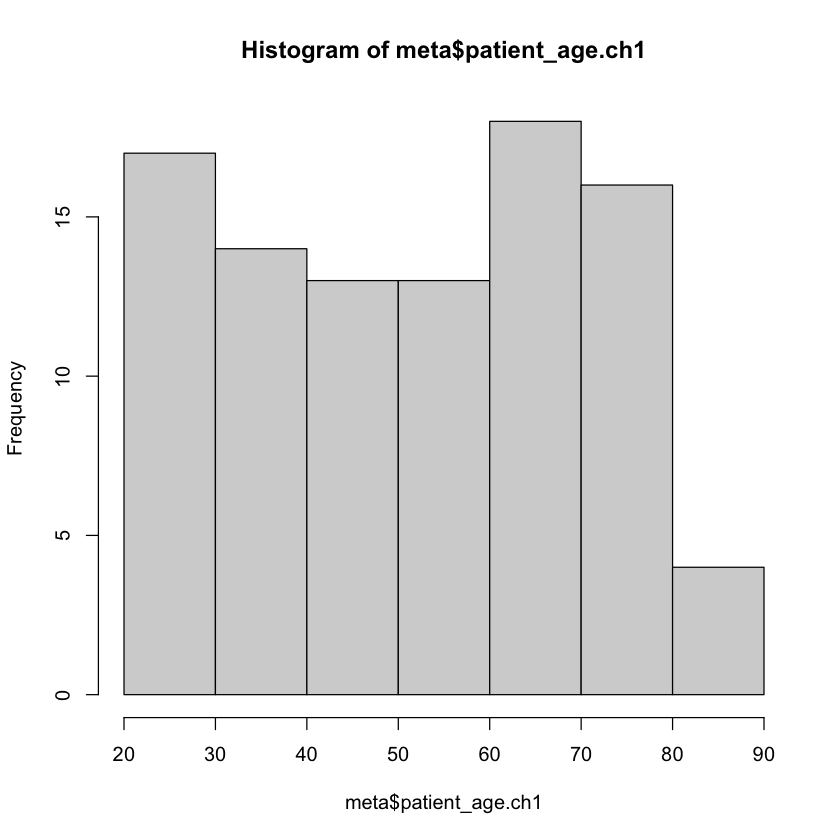

In [7]:
hist(meta$patient_age.ch1)

Next, generate a bar plot using [`barplot()`](https://www.statmethods.net/graphs/bar.html) of the gender. 

The input for `barplot()` is a table of counts for each condition, not a list of the conditions. 

Ex: instead of a list/vector with "female", "female", "female", "male", we need to use the [`table()`](https://www.statology.org/table-function-in-r/) function to get the counts, female: 3 and male: 1.

In [8]:
gender_table <- table(meta$gender.ch1)
gender_table


female   male 
    47     49 

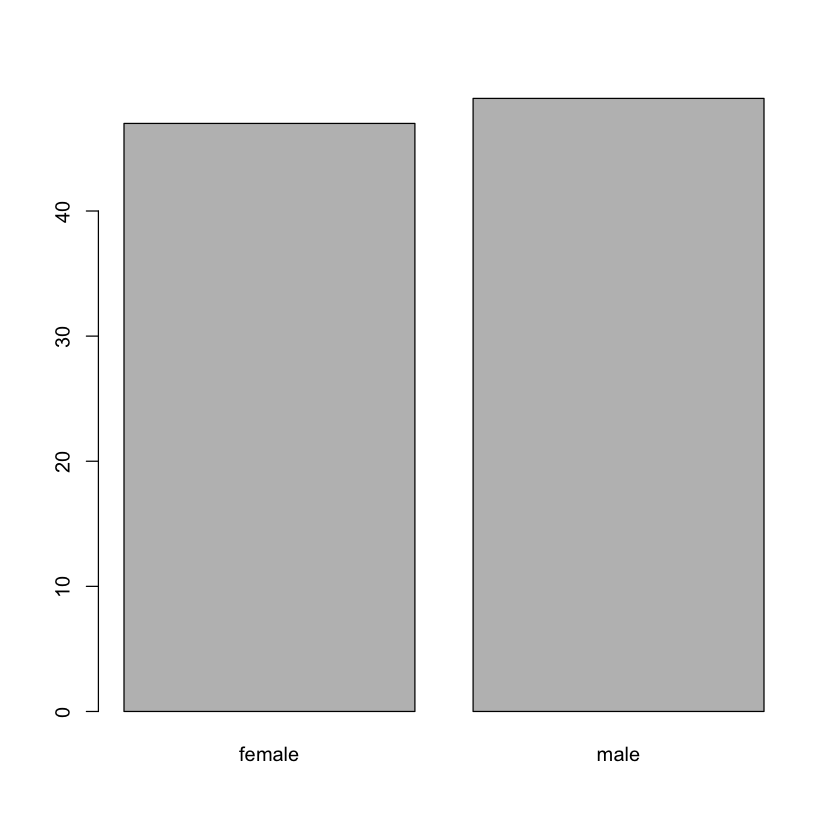

In [9]:
barplot(gender_table)

<div class="alert alert-block alert-info">
    <h3>R Practice for basic visualizations: barplot</h3><br>
    
<p>
    Generate a stacked bar plot using <code>barplot()</code> of the disease and inflammation status. The x-axis should be divided by disease, and each disease will be subdivided into inflamed/uninflamed.
    
Hints:
- You can look here for [examples]((https://www.statmethods.net/graphs/bar.html))
- Generate the counts table with disease and inflammation status
- You can use the `beside=` parameter when calling `barplot()` so the groups aren't stacked on top of each other
- Use the `legend=` parameter to include the legend in the plot
- You can also add title (`main=`), x-axis label (`xlab=`), y-axis label (`ylab=`), colors (`col=`)
</p>
    

</div>

In [10]:
table(meta$disease.ch1, meta$inflammation_status.ch1)

         
          inflamed uninflamed
  CD            19         15
  Control        0         42
  IBDu           1          0
  OTHER          2          4
  UC            10          3

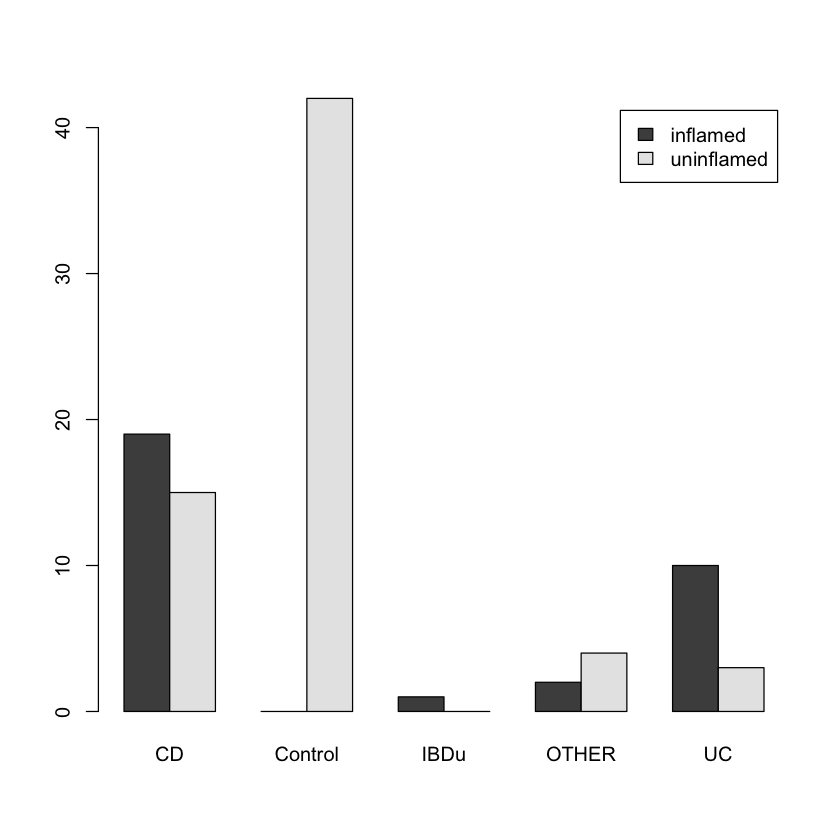

In [11]:
barplot(table(meta$inflammation_status.ch1, meta$disease.ch1), beside=T,legend=T)

**Scatter plots:**

Let's make a scatter plot for the first two genes in our `expr2` data frame.

[`plot()`](https://www.w3schools.com/r/r_graph_plot.asp) : general function that creates various plots depending on the input. We can input two vectors to generate a scatter plot

Note: we just need the gene expression values, not the gene ID and symbol, so we need to subset the data by using `-c()` to designate which columns we don't need.

In [12]:
x1 <- expr2[1,-c(1,2)]
x2 <- expr2[2,-c(1,2)]

plot(x1,x2)

ERROR: Error in plot.new(): figure margins too large


There's an error! Let's make sure the format of our data matches what is needed for the input.

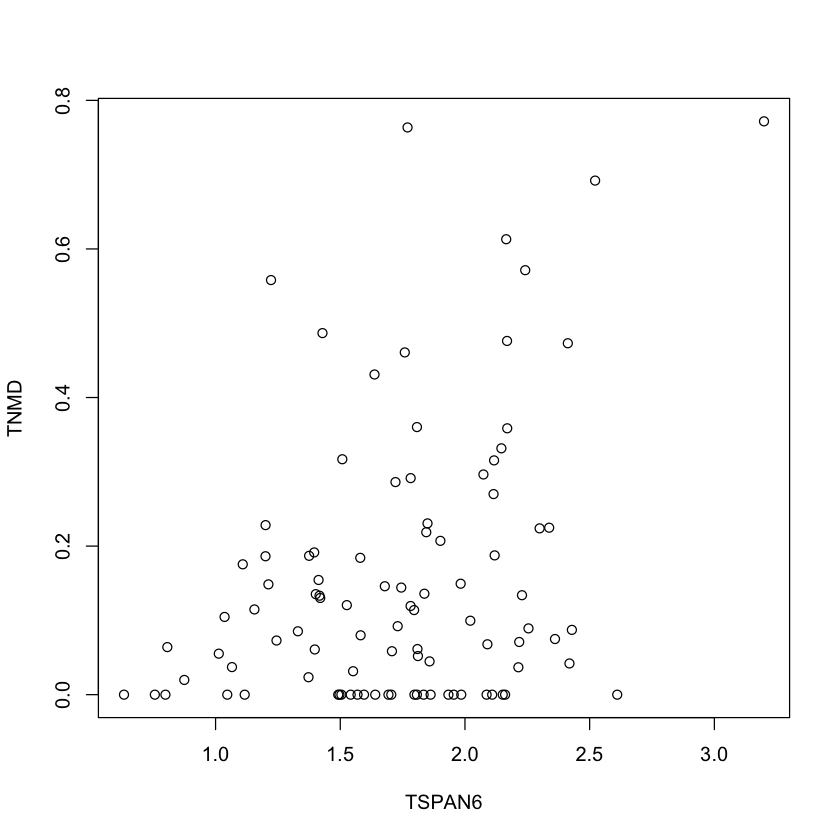

In [13]:
x1 <- as.vector(expr2[1,-c(1,2)])
x2 <- as.vector(expr2[2,-c(1,2)])

plot(x1,x2, xlab=expr2[1,2], ylab=expr2[2,2])

We can add a title to our plot with the genes by using [`paste()`](https://www.digitalocean.com/community/tutorials/paste-in-r). `paste()` allows you to combine variables and/or strings into a single string. 

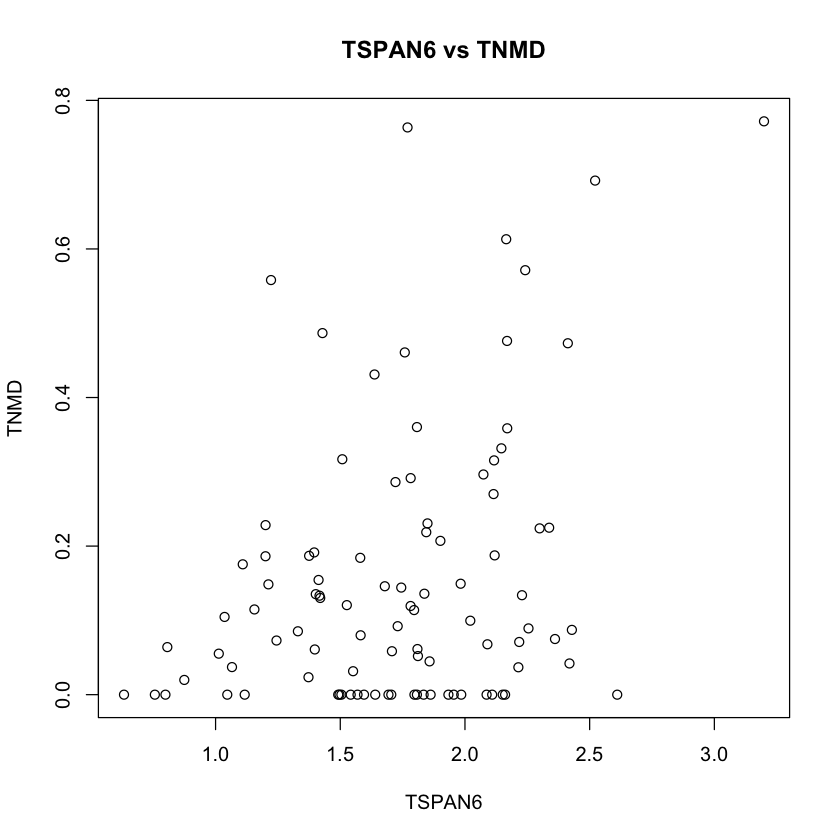

In [14]:
x1 <- as.vector(expr2[1,-c(1,2)])
x2 <- as.vector(expr2[2,-c(1,2)])

plot(x1,x2, xlab=expr2[1,2], ylab=expr2[2,2], main=paste(expr2[1,2],'vs',expr2[2,2]))

We can also plot data using gene names. Let's plot FGR and GCLC. 

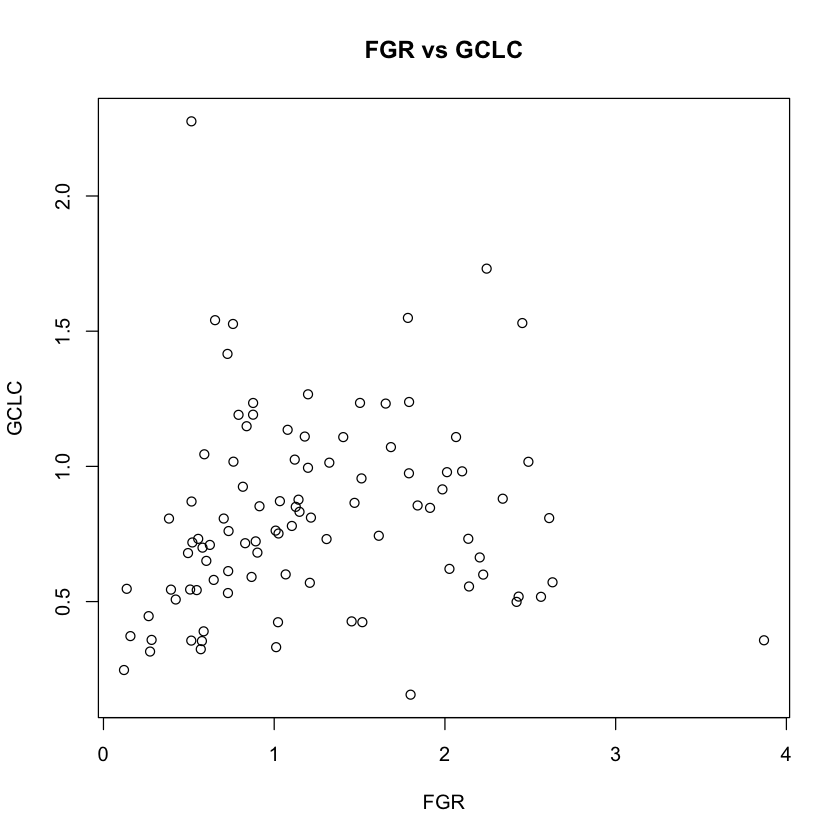

In [15]:
x1 <- as.vector(expr2[expr2$SYMBOL == 'FGR',-c(1,2)])
x2 <- as.vector(expr2[expr2$SYMBOL == 'GCLC',-c(1,2)])

plot(x1,x2, xlab='FGR', ylab='GCLC',main='FGR vs GCLC')

**Boxplots**

We can also compare the expression of certain genes between certain groups using boxplots. 

[`boxplot()`](https://www.tutorialspoint.com/r/r_boxplots.htm) : generates a boxplot

Let's create a new dataframe `tyk2` for the gene 'TYK2', where the gene expression is matched to the sample metadata.

In [16]:
tyk2 <- data.frame(t(expr2[expr2$SYMBOL == 'TYK2',-c(1,2)]))
names(tyk2)[1] <- 'TYK2'
tyk2 <- merge(meta, tyk2, by.x=0,by.y=0)
head(tyk2)

,Row.names,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1,TYK2
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
1,CD_I_LI_F_22,CD_I_LI_F_22,CD,female,inflamed,1,43,large_intestine,3.038121
2,CD_I_LI_F_29,CD_I_LI_F_29,CD,female,inflamed,NA,25,large_intestine,2.664913
3,CD_I_LI_M_15,CD_I_LI_M_15,CD,male,inflamed,4,25,large_intestine,3.107976
4,CD_I_LI_M_24,CD_I_LI_M_24,CD,male,inflamed,NA,55,large_intestine,3.216673
5,CD_I_LI_M_36,CD_I_LI_M_36,CD,male,inflamed,0,73,large_intestine,3.096699
6,CD_I_LI_M_49,CD_I_LI_M_49,CD,male,inflamed,1,22,large_intestine,3.576422


Then use `boxplot()` to plot the TYK2 gene expression by disease.

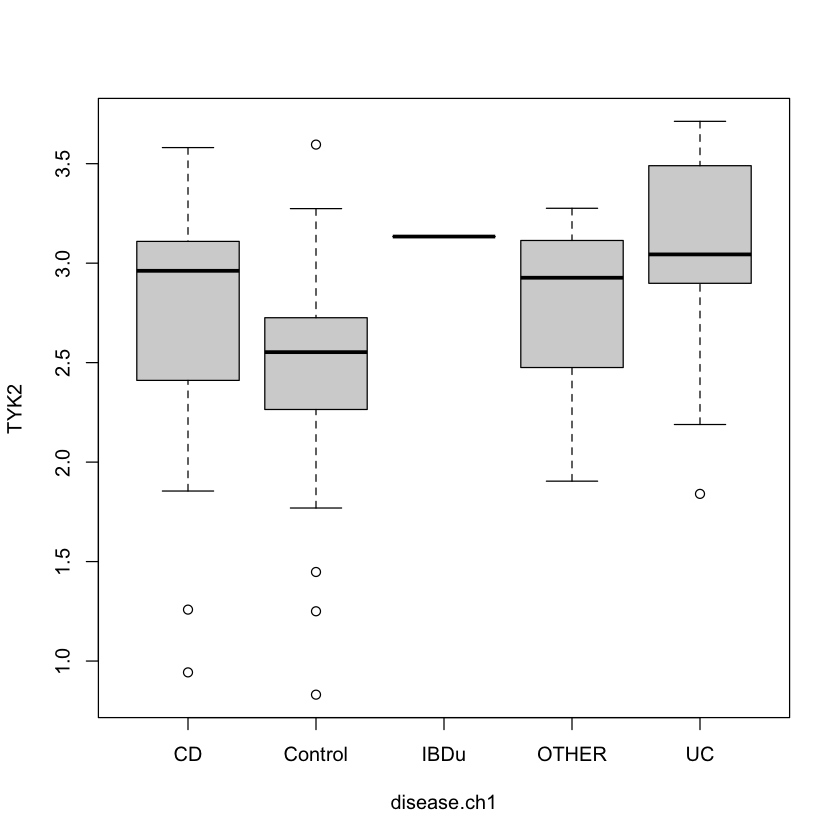

In [17]:
boxplot(TYK2 ~ disease.ch1, tyk2)

<div class="alert alert-block alert-info">
    <h3>R Practice for basic visualizations: boxplot</h3><br>
    <p>Generate a boxplot comparing STAT3 between Control vs CD vs UC samples only
    
Hints:
- You can look here for [examples](https://www.statmethods.net/graphs/boxplot.html) 
- Look at the [`subset=`](https://stackoverflow.com/questions/38908230/how-do-i-subset-a-box-plots-in-r) parameter in boxplot() which uses the format `dataframe$column %in% c(variable1, variable2)`
- Can also add title, x and y labels, colors
   </p>
</div>

In [18]:
stat3 <- data.frame(t(expr2[expr2$SYMBOL == 'STAT3',-c(1,2)]))
names(stat3)[1] <- 'STAT3'
stat3 <- merge(meta, stat3, by.x=0,by.y=0)
head(stat3)

,Row.names,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1,STAT3
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>
1,CD_I_LI_F_22,CD_I_LI_F_22,CD,female,inflamed,1,43,large_intestine,3.812534
2,CD_I_LI_F_29,CD_I_LI_F_29,CD,female,inflamed,NA,25,large_intestine,3.215992
3,CD_I_LI_M_15,CD_I_LI_M_15,CD,male,inflamed,4,25,large_intestine,3.076667
4,CD_I_LI_M_24,CD_I_LI_M_24,CD,male,inflamed,NA,55,large_intestine,3.081222
5,CD_I_LI_M_36,CD_I_LI_M_36,CD,male,inflamed,0,73,large_intestine,3.330625
6,CD_I_LI_M_49,CD_I_LI_M_49,CD,male,inflamed,1,22,large_intestine,3.230536


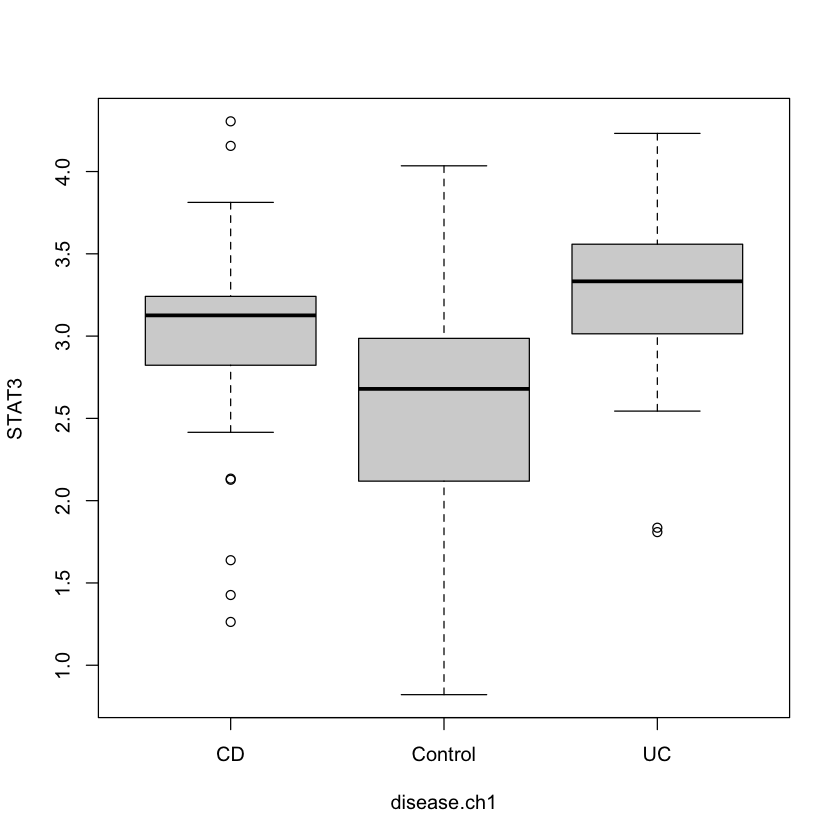

In [19]:
boxplot(STAT3 ~ disease.ch1, stat3, subset=disease.ch1 %in% c('Control','CD','UC'))

<div class="alert alert-block alert-success">

<p>You should have 3 boxes for CD, Control and UC showing the expression of STAT3. </p>

</div>

### Visualizations using ggplot

In [20]:
library('ggplot2')

[ggplot2](https://datacarpentry.org/R-ecology-lesson/04-visualization-ggplot2.html) works primarily with dataframes. We have to supply ggplot with a dataframe. As we go through ggplot, a key thing to notice is how the plot can continually be enhaanced by adding layers and themes (generally indicated by a ```+``` sign and a following statement) to an existing plot. 

Here is a ggplot data visualization cheat sheet for your own reference: https://github.com/rstudio/cheatsheets/blob/main/data-visualization-2.1.pdf

Let's first create a new data frame called `data` as before with only TYK2 and STAT3. We can subset the data using the format `dataframe$column %in% c(variable1, variable2)`.

In [21]:
data <- data.frame(t(expr2[expr2$SYMBOL %in% c('TYK2','STAT3'),-c(1,2)]))
names(data) <- c('TYK2','STAT3')
head(data)

,TYK2,STAT3
,<dbl>,<dbl>
CD_I_LI_F_22,3.038121,3.812534
CD_I_LI_F_29,2.664913,3.215992
CD_I_LI_M_15,3.107976,3.076667
CD_I_LI_M_24,3.216673,3.081222
CD_I_LI_M_36,3.096699,3.330625
CD_I_LI_M_49,3.576422,3.230536


Now merge `data` with `meta` into the same variable `data` so we have the metadata information.

In [22]:
data <- merge(meta, data, by.x=0, by.y=0)
head(data)

,Row.names,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1,TYK2,STAT3
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
1,CD_I_LI_F_22,CD_I_LI_F_22,CD,female,inflamed,1,43,large_intestine,3.038121,3.812534
2,CD_I_LI_F_29,CD_I_LI_F_29,CD,female,inflamed,NA,25,large_intestine,2.664913,3.215992
3,CD_I_LI_M_15,CD_I_LI_M_15,CD,male,inflamed,4,25,large_intestine,3.107976,3.076667
4,CD_I_LI_M_24,CD_I_LI_M_24,CD,male,inflamed,NA,55,large_intestine,3.216673,3.081222
5,CD_I_LI_M_36,CD_I_LI_M_36,CD,male,inflamed,0,73,large_intestine,3.096699,3.330625
6,CD_I_LI_M_49,CD_I_LI_M_49,CD,male,inflamed,1,22,large_intestine,3.576422,3.230536


Now let's initialize a basic ggplot with our `data` data frame, using the TYK2 and STAT3 columns of data. The aes() function is what we will use to specify the X and Y axes

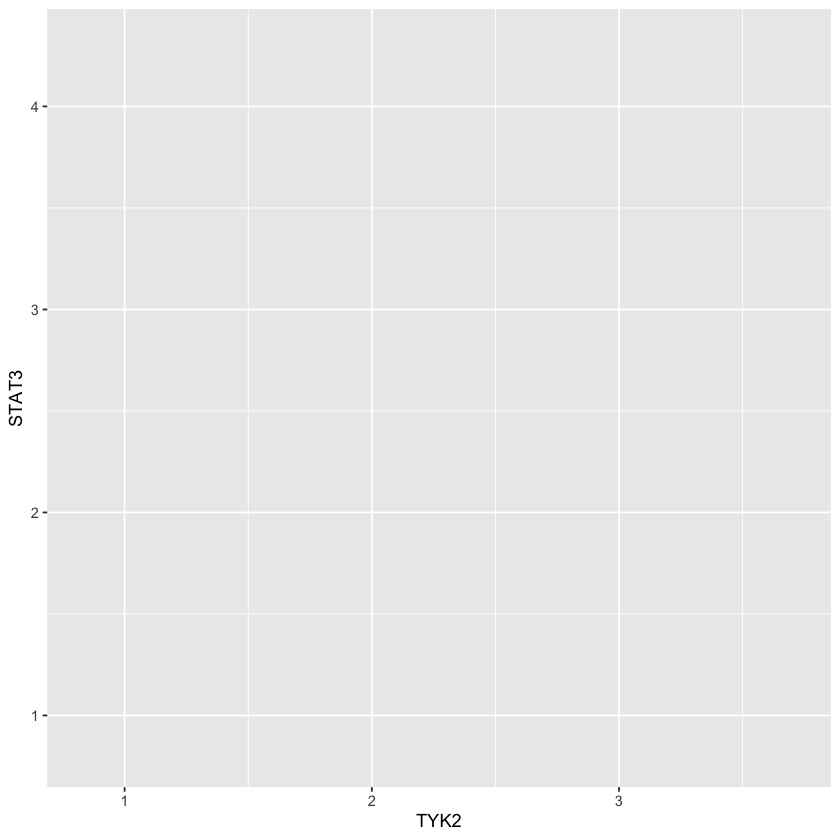

In [23]:
ggplot(data, aes(x=TYK2, y=STAT3))

Do you see a blank ggplot? If so, don't worry, you did this step correctly. While we have x and y labels that match the columns we initialized the plot with, we don't see any plotted data. This is because ggplot does not make assumptions about the plot you are meaning to draw. Initializing the ggplot only tells ggplot what dataframe and what x and y columns from the dataframe should be used.

Now let's make a scatterplot. We will do this by adding on a layer using ```geom_point()```.

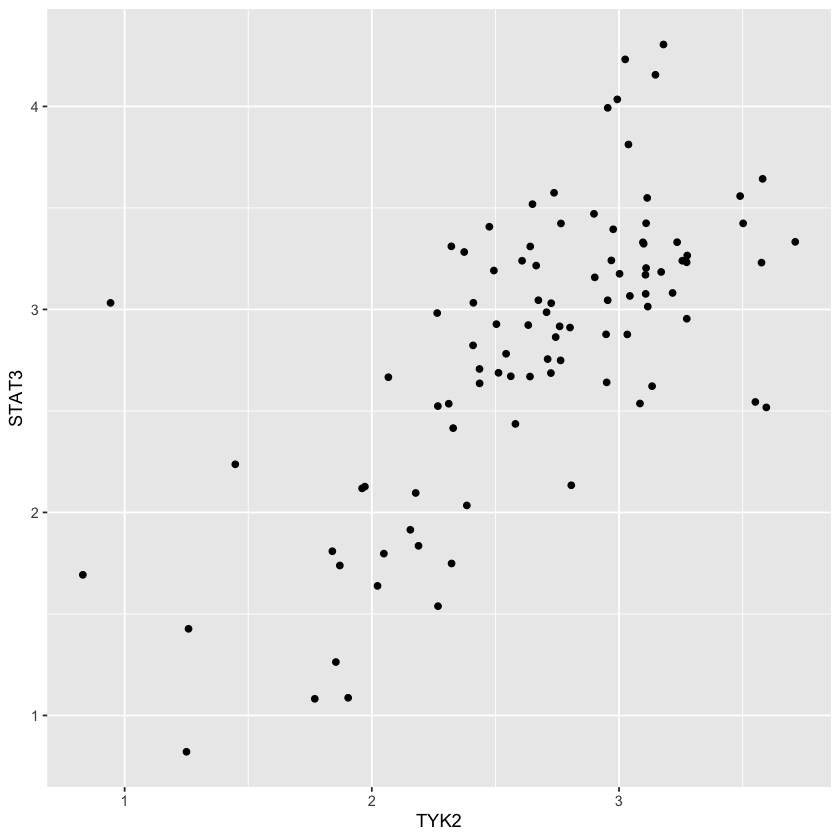

In [24]:
ggplot(data, aes(x=TYK2, y=STAT3)) +
    geom_point()

From here, we can add on a smoothing layer using the method "lm" to draw a line of best fit. 

`geom_smooth()` using formula = 'y ~ x'


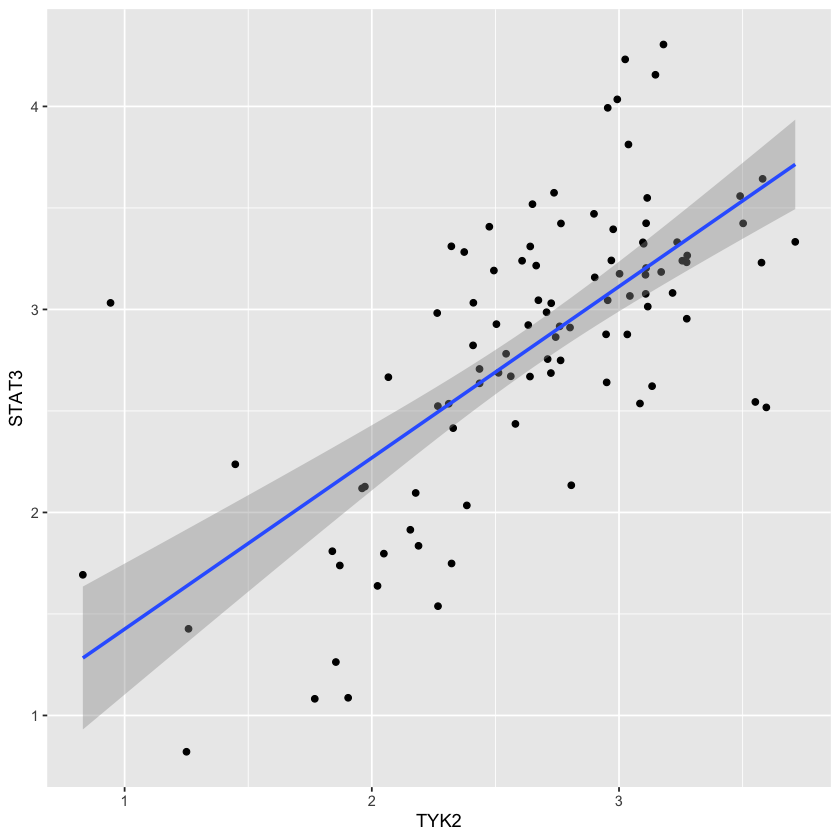

In [25]:
ggplot(data, aes(x=TYK2, y=STAT3)) +
    geom_point() +
    geom_smooth(method='lm')

We can also adjust the x and y limits.

`geom_smooth()` using formula = 'y ~ x'


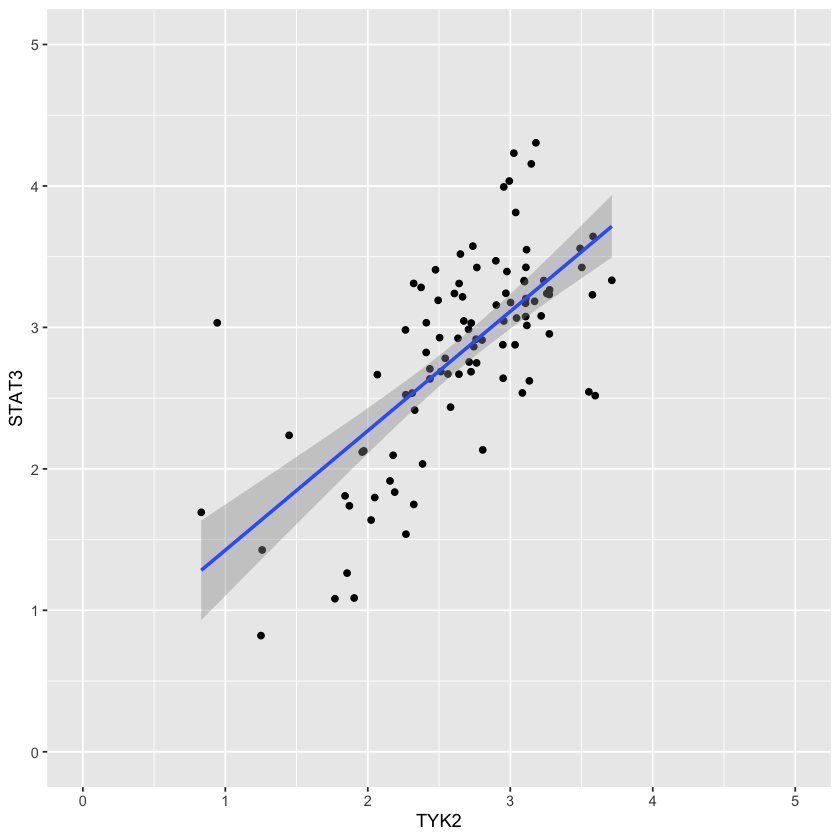

In [26]:
ggplot(data, aes(x=TYK2, y=STAT3)) + 
    geom_point() + 
    geom_smooth(method='lm') + 
    xlim(c(0, 5)) + 
    ylim(c(0, 5))

<div class="alert alert-block alert-info">
    <h3>R Practice for ggplot</h3><br>
<p>Generate a box plot like we did before (STAT3 expression for Control, CD, UC) but use ggplot this time. </p>
<br>

You can look here for [examples](http://www.sthda.com/english/wiki/ggplot2-box-plot-quick-start-guide-r-software-and-data-visualization)
    
<br>
<p>Suggestions to include:</p>  
<ul>
<li>Ordering the box plots (Control, CD, UC)</li>
    <li>Labels for title, x and y axis (<code>labs()</code>)</li>
<li>Colors for each disease group</li>
    <li>Add points for the samples (look at <code>geom_point()</code> or <code>geom_jitter()</code>)</li>
<li>Font size</li>
<li>ggplot theme</li>
    </ul>

</div>

In [27]:
data <- data.frame(t(expr2[which(expr2$SYMBOL %in% c('TYK2','STAT3')),-c(1,2)]))
names(data) <- c('TYK2','STAT3')
data <- merge(meta, data, by.x=0, by.y=0)
data <- data[data$disease.ch1 %in% c('Control','UC','CD'),]
head(data)

,Row.names,title,disease.ch1,gender.ch1,inflammation_status.ch1,nancy_score.ch1,patient_age.ch1,site_taken.ch1,TYK2,STAT3
,<I<chr>>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
1,CD_I_LI_F_22,CD_I_LI_F_22,CD,female,inflamed,1,43,large_intestine,3.038121,3.812534
2,CD_I_LI_F_29,CD_I_LI_F_29,CD,female,inflamed,NA,25,large_intestine,2.664913,3.215992
3,CD_I_LI_M_15,CD_I_LI_M_15,CD,male,inflamed,4,25,large_intestine,3.107976,3.076667
4,CD_I_LI_M_24,CD_I_LI_M_24,CD,male,inflamed,NA,55,large_intestine,3.216673,3.081222
5,CD_I_LI_M_36,CD_I_LI_M_36,CD,male,inflamed,0,73,large_intestine,3.096699,3.330625
6,CD_I_LI_M_49,CD_I_LI_M_49,CD,male,inflamed,1,22,large_intestine,3.576422,3.230536


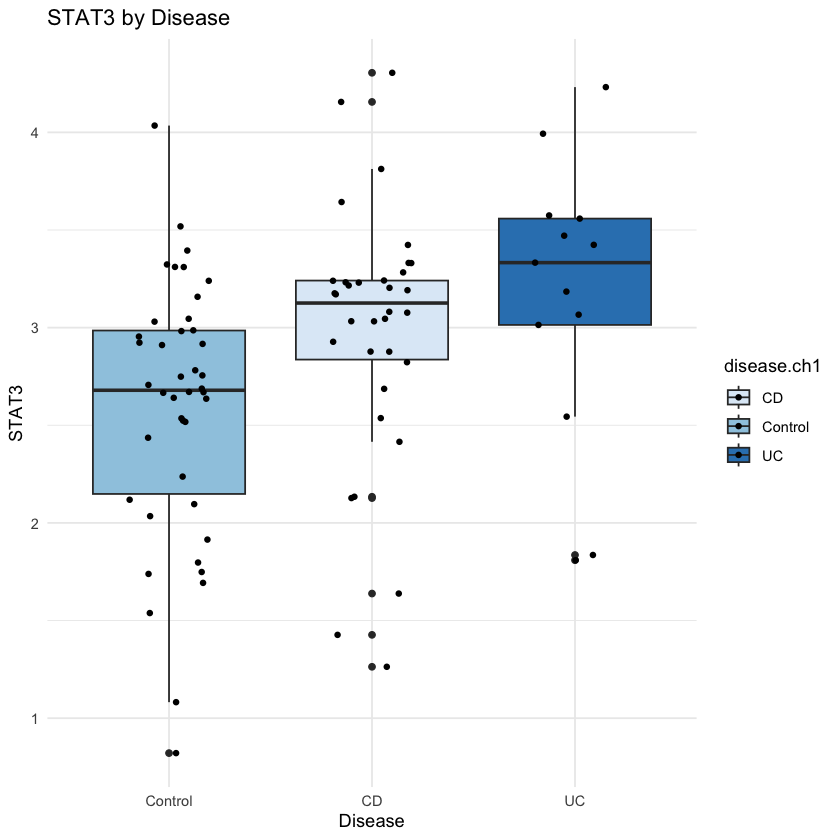

In [28]:
ggplot(data, aes(y=STAT3, x=reorder(disease.ch1,STAT3), fill=disease.ch1)) +
    scale_fill_brewer(palette="Blues") + 
    geom_boxplot() +
    geom_jitter(shape=16, position=position_jitter(0.2)) +
    theme_minimal() +
    labs(title='STAT3 by Disease', x='Disease')

<div class="alert alert-block alert-success">

You should have three boxes showing the expression of STAT3 for Control, Disease and UC.
    
</div>

### [Pheatmap](https://www.rdocumentation.org/packages/COMPASS/versions/1.10.2/topics/pheatmap)
Pheatmap enables you to draw clustered heatmaps, where you can control more of the graphical parameters.

In [29]:
library(pheatmap)

Let's see how the top genes identified in this [meta-analysis paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8440637/) perform in our dataset.
First, read in the file `data/PMC8440637_top_genes.txt` into a dataframe `gene_table` so we can see the top 10 up- and top 10 down-regulated genes from this paper.

In [30]:
# Get list of top genes from file
gene_table <- read.table('data/PMC8440637_top_genes.txt',sep='\t',header=TRUE)
genes <- as.vector(gene_table$Symbol)
genes

[1] "LCN2"   "DUOXA2" "PI3"    "CXCL8"  "MMP3"   "REG3A"  "CHI3L1" "MMP7"  
 [9] "DUOX2"  "MMP9"   "AQP8"   "CLDN8"  "HMGCS2" "UGT2A3" "GUCA2B" "PCK1"  
[17] "TRPM6"  "CHP2"   "ANPEP"  "ADH1C"

Now let's create a new data frame `data2` by getting the expression for these genes from the `expr2` data frame.

In [31]:
data2 <- data.frame(expr2[expr2$SYMBOL %in% genes,-c(1)])
rownames(data2) <- data2$SYMBOL
data2 <- data2[-1]
head(data2)

,CD_I_LI_F_22,CD_I_LI_F_29,CD_I_LI_M_15,CD_I_LI_M_24,CD_I_LI_M_36,CD_I_LI_M_49,CD_I_LI_M_5,CD_I_SI_F_20,CD_I_SI_F_25,CD_I_SI_F_3,⋯,UC_I_LI_F_45,UC_I_LI_F_8,UC_I_LI_M_1,UC_I_LI_M_34,UC_I_LI_M_9,UC_M_LI_F_18,UC_NA_LI_F_2,UC_U_LI_F_40,UC_U_LI_M_33,UC_U_SI_F_17
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GUCA2B,0.9100835,2.0026685,0.41550718,0.9289305,1.4996409,0.9352106,2.0974018,1.6201820,1.3735485,0.2407941,⋯,0.1695968,0.4892651,1.4616615,0.3909239,0.000000,2.8727507,0.4944352,3.8641953,2.3575713,3.3671027
MMP9,3.9103616,3.1270456,4.31030639,4.8791893,2.2166927,3.6986020,3.3881088,3.1668876,2.3369411,3.1055324,⋯,4.6785322,5.5062742,4.8087312,5.0277874,4.576222,1.1052866,5.1833441,3.0712015,3.1972067,1.5197232
AQP8,1.4608567,1.0882050,1.06188952,1.3181520,2.5710002,2.6321622,3.6898090,1.6940878,0.8098897,0.9888309,⋯,0.3589359,1.2749828,2.2274121,1.1563056,1.372183,4.2464460,1.8750860,4.4992228,3.7360874,1.2941544
TRPM6,0.4069134,0.2737872,0.37388981,0.6088336,0.9903624,0.0000000,0.5374555,0.6036781,0.2400667,0.8260684,⋯,0.3246013,0.5992771,0.9109847,0.3190608,0.191463,0.2315188,0.5335968,0.3713166,0.2542918,0.5522953
PI3,5.0554557,0.6766387,0.56367269,2.3401024,3.2999285,1.3874637,2.5014523,1.7930753,3.4372882,3.2494283,⋯,4.6615222,5.5048192,5.4509955,2.8623666,4.412991,2.5366211,1.9559029,5.2885397,3.9945426,1.7929471
PCK1,1.7634972,2.5646339,0.07169721,0.7067690,2.2504578,1.6482913,3.6047285,3.6010668,0.5909046,1.5236709,⋯,0.5537437,1.7015667,1.1877184,0.5506638,1.250861,0.6975574,0.1621461,2.2550930,1.4726372,3.9677093


Plot the gene expression using `pheatmap()`

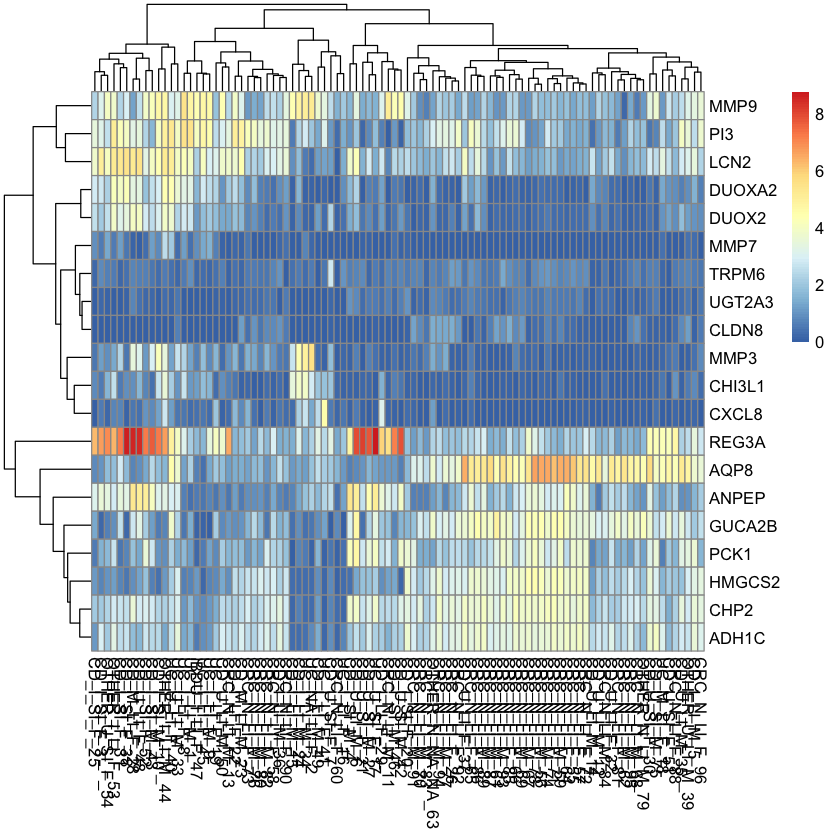

In [32]:
pheatmap(data2)

Let's increase the size so the heatmap isn't compressed using `options(repr.plot.width = #, repr.plot.height = #)`.

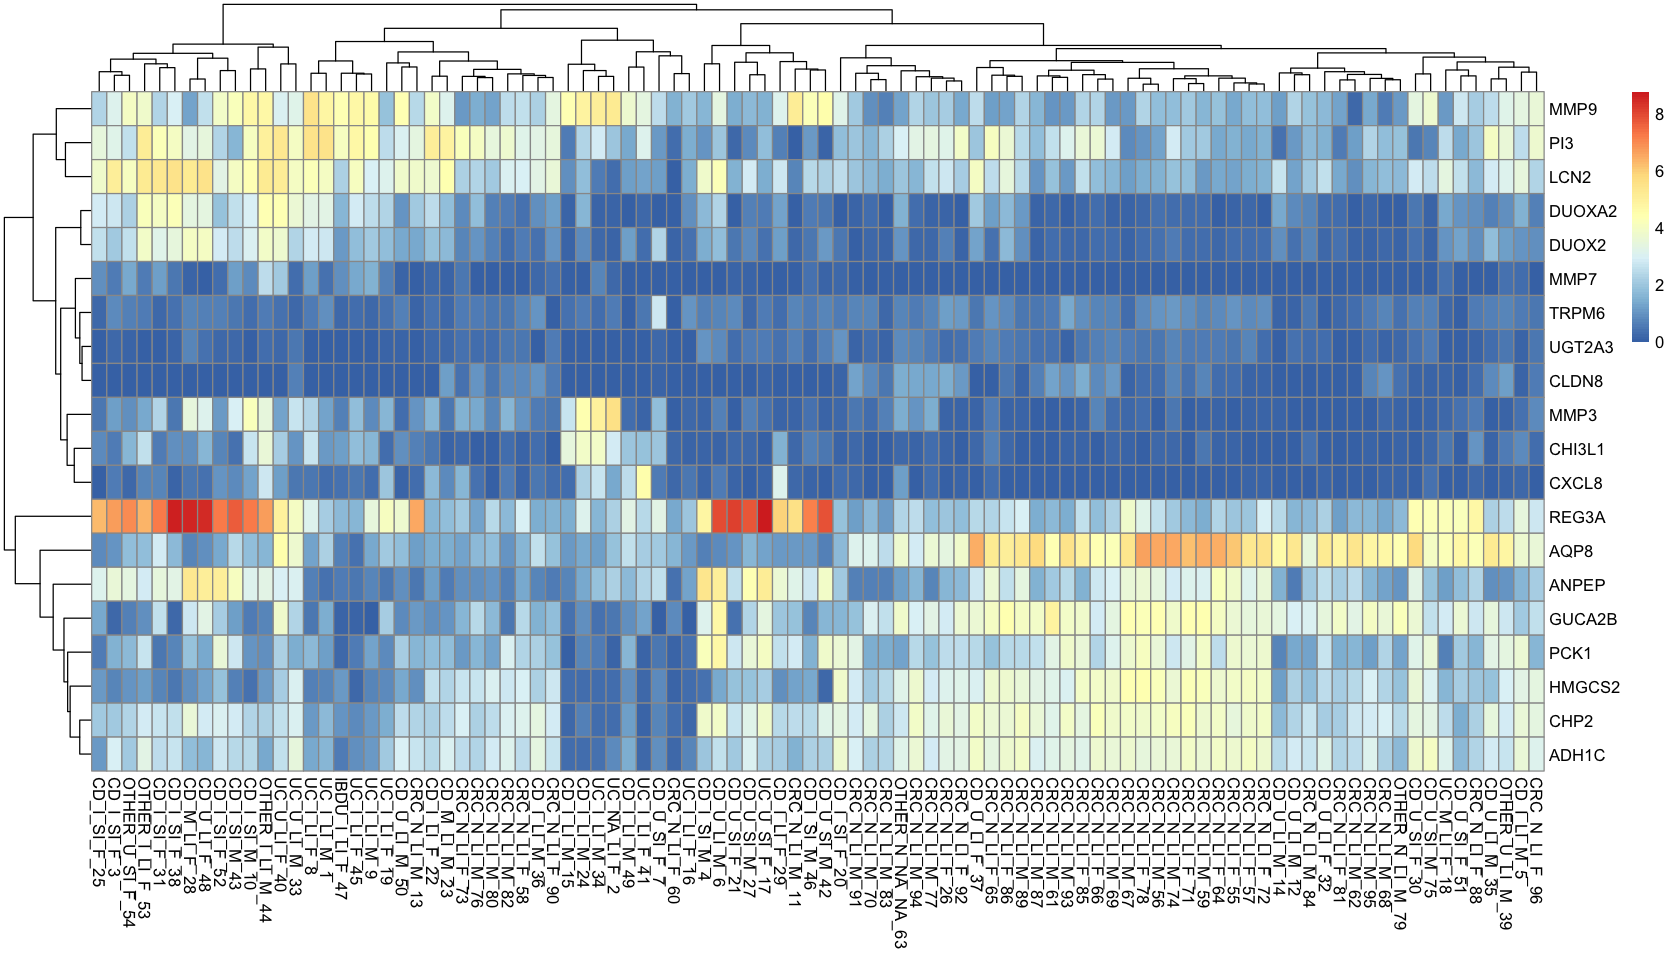

In [33]:
options(repr.plot.width = 14, repr.plot.height = 8)
pheatmap(data2)

<div class="alert alert-block alert-info">
    <h3>R Practice for pheatmap</h3><br>
    <p>Let's change some of the parameters so we can try to explain what we're seeing with the data.</p>
    <ul>
    <li>Subset the samples so you're only showing the Control, CD and UC samples</li>
    <li>Add annotations to the samples using the meta data frame (try adding one or more of the columns to see if any of the characteristics describe the change in gene expression for the samples)</li>
    <li>Add annotations to the genes to show whether they were classified as up or down regulated (Hint: look in the file for the top genes)</li>
    <li>Can also change some of the aesthetics</li>
    </ul>
</div>

1. Create a new dataframe `sample_annotations` with only the Control, CD and UC samples from `meta`

*Hint: use this format `dataframe$column %in% c(variable1, variable2)`*

In [34]:
# Sample annotations
sample_annotations <- meta[meta$disease.ch1 %in% c('Control','CD','UC'),]
colnames(sample_annotations) <- c('title','disease', 'gender', 'inflammation_status', 'nancy_score', 
                                  'patient_age', 'site_taken')
sample_annotations <- sample_annotations[with(sample_annotations, order(disease, inflammation_status)),]
head(sample_annotations)

,title,disease,gender,inflammation_status,nancy_score,patient_age,site_taken
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
CD_I_SI_F_3,CD_I_SI_F_3,CD,female,inflamed,4,56,small_intestine
CD_I_SI_M_4,CD_I_SI_M_4,CD,male,inflamed,NA,33,small_intestine
CD_I_LI_M_5,CD_I_LI_M_5,CD,male,inflamed,2,28,large_intestine
CD_I_SI_M_10,CD_I_SI_M_10,CD,male,inflamed,4,28,small_intestine
CD_I_LI_M_15,CD_I_LI_M_15,CD,male,inflamed,4,25,large_intestine
CD_I_SI_F_20,CD_I_SI_F_20,CD,female,inflamed,0,43,small_intestine


2. Create a new dataframe `data3` with only the Control, CD and UC samples from `data2` 

*Hint: get a list of sample IDs for Control, CD and UC and use those sample IDs to filter `data2`*

In [35]:
# Subset samples to keep Control, CD and UC
samples_to_keep <- rownames(sample_annotations)
data3 <- data2[,samples_to_keep]
head(data3)

,CD_I_SI_F_3,CD_I_SI_M_4,CD_I_LI_M_5,CD_I_SI_M_10,CD_I_LI_M_15,CD_I_SI_F_20,CD_I_LI_F_22,CD_M_LI_M_23,CD_I_LI_M_24,CD_I_SI_F_25,⋯,UC_I_LI_M_9,UC_I_LI_F_16,UC_M_LI_F_18,UC_I_LI_F_19,UC_I_LI_M_34,UC_I_LI_F_41,UC_I_LI_F_45,UC_U_SI_F_17,UC_U_LI_M_33,UC_U_LI_F_40
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GUCA2B,0.2407941,3.0819054,2.0974018,0.5426277,0.41550718,1.6201820,0.9100835,1.0092563,0.9289305,1.3735485,⋯,0.000000,0.0000000,2.8727507,2.1535409,0.3909239,1.2948587,0.1695968,3.3671027,2.3575713,3.8641953
MMP9,3.1055324,1.6670066,3.3881088,4.6764298,4.31030639,3.1668876,3.9103616,3.1374879,4.8791893,2.3369411,⋯,4.576222,2.0333884,1.1052866,1.9174945,5.0277874,3.4239564,4.6785322,1.5197232,3.1972067,3.0712015
AQP8,0.9888309,0.6162715,3.6898090,1.7728501,1.06188952,1.6940878,1.4608567,1.4124347,1.3181520,0.8098897,⋯,1.372183,1.1058725,4.2464460,2.0866356,1.1563056,2.1287887,0.3589359,1.2941544,3.7360874,4.4992228
TRPM6,0.8260684,0.6578086,0.5374555,0.3187344,0.37388981,0.6036781,0.4069134,0.2409811,0.6088336,0.2400667,⋯,0.191463,1.0312253,0.2315188,0.3622653,0.3190608,0.5009462,0.3246013,0.5522953,0.2542918,0.3713166
PI3,3.2494283,0.9980329,2.5014523,4.0539565,0.56367269,1.7930753,5.0554557,4.8870278,2.3401024,3.4372882,⋯,4.412991,1.4467754,2.5366211,2.5195496,2.8623666,3.1121321,4.6615222,1.7929471,3.9945426,5.2885397
PCK1,1.5236709,4.2058949,3.6047285,1.0177131,0.07169721,3.6010668,1.7634972,1.8378285,0.7067690,0.5909046,⋯,1.250861,0.3528973,0.6975574,0.8189116,0.5506638,0.1203770,0.5537437,3.9677093,1.4726372,2.2550930


3. Create a new dataframe `gene_annotations` with the regulation information from the `gene_table` dataframe. 

Hints:
- Subset `gene_table` so it only has the Symbol and Regulation columns
- Change the rownames to the Symbol using `rownames(gene_annotations) <-`
- Remove the Symbol column after setting the rownames
- The resulting dataframe should have the genes as the rownames and one column for Regulation with up/down

In [36]:
# Gene annotations
gene_annotations <- gene_table[,c(1,5)]
rownames(gene_annotations) <- gene_annotations$Symbol
gene_annotations <- gene_annotations[-1]
colnames(gene_annotations) <- c('regulation')
head(gene_annotations)

,regulation
,<chr>
LCN2,up
DUOXA2,up
PI3,up
CXCL8,up
MMP3,up
REG3A,up


4. Plot the data using `pheatmap()`. 

Set the row (gene) and column (sample) annotations using the parameters `annotation_row=` and `annotation_col=`. 

For the sample annotations, try different subsets of the columns to see which of the sample metadata best explains the heatmap. Ex: you can try just gender, gender and disease, or other combinations.

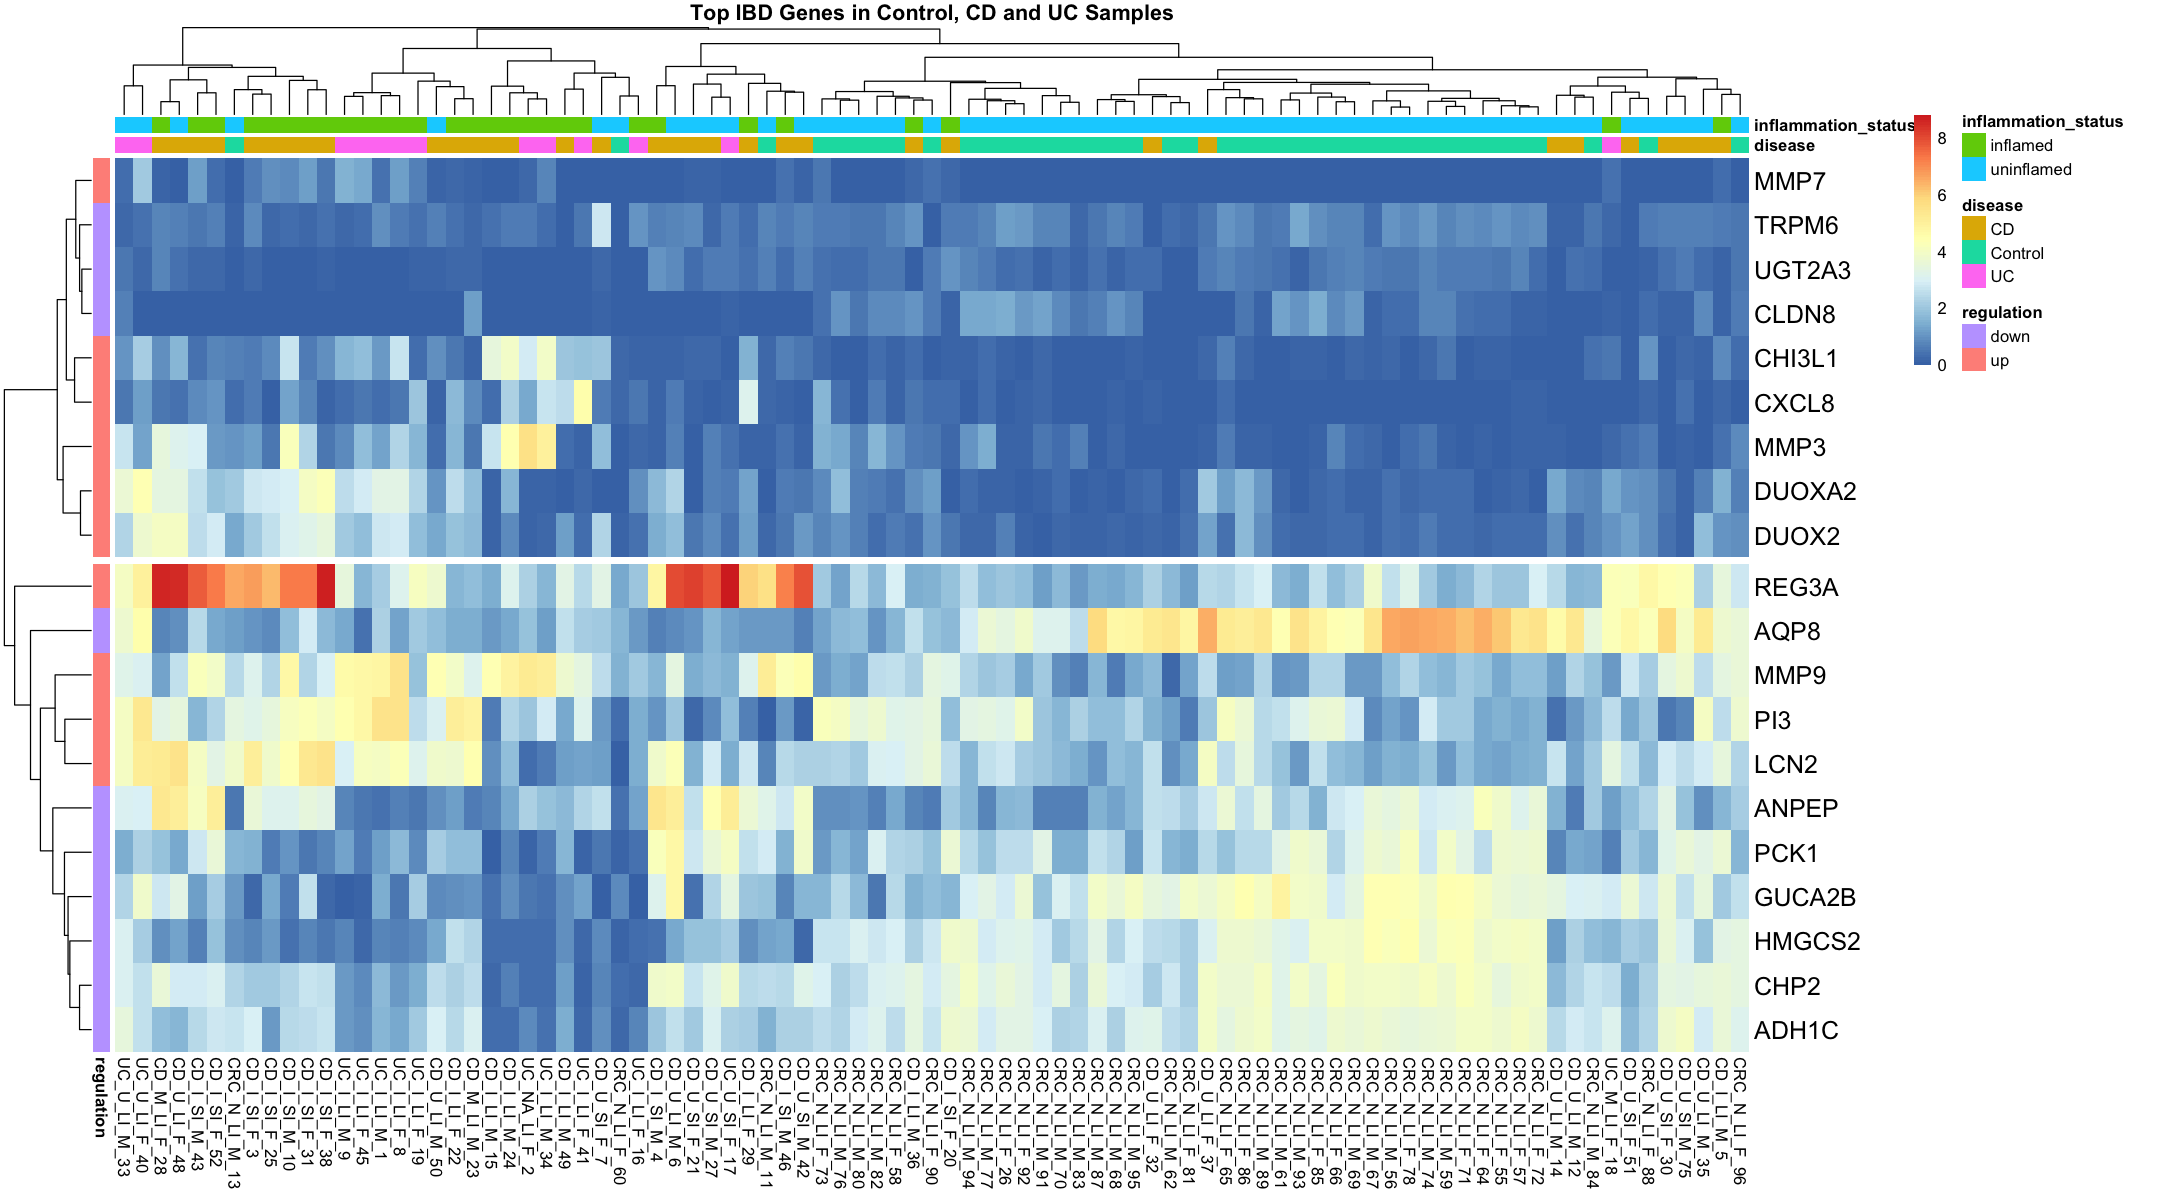

In [37]:
options(repr.plot.width = 18, repr.plot.height = 10)
pheatmap(data3, cutree_rows = 2, annotation_col=sample_annotations[c(2,4)], annotation_row=gene_annotations,
        fontsize_row=15, main='Top IBD Genes in Control, CD and UC Samples')

Plot 2. Remove column clustering, only use UC samples

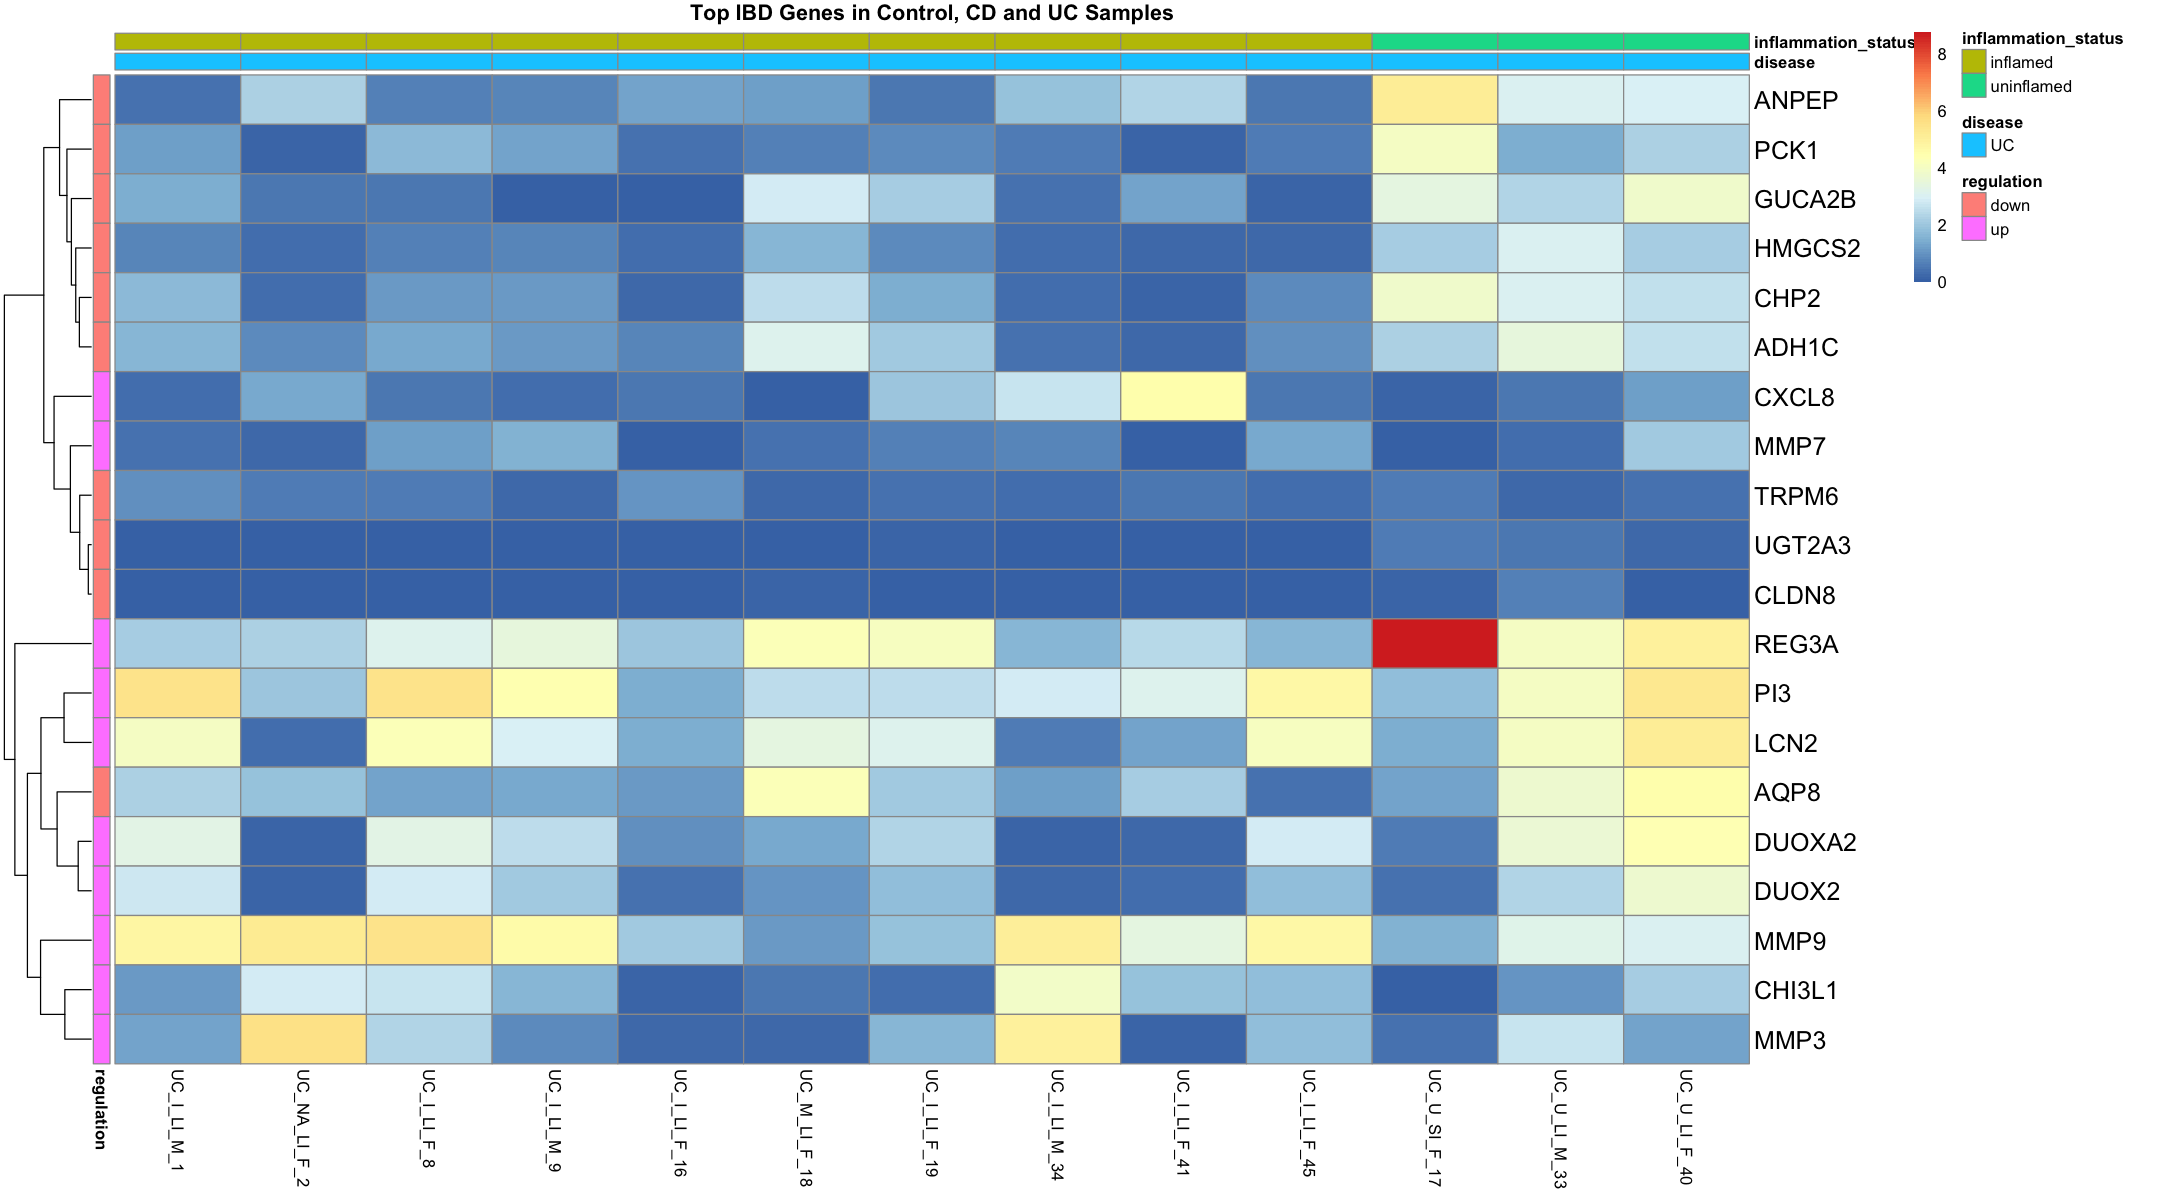

In [38]:
options(repr.plot.width = 18, repr.plot.height = 10)
samples_to_keep <- rownames(sample_annotations[sample_annotations$disease %in% c('UC'),])
data4 <- data2[,samples_to_keep]
pheatmap(data4, cuttree_rows=2, cluster_cols=F, 
         annotation_col=sample_annotations[c(2,4)], annotation_row=gene_annotations,
        fontsize_row=15, main='Top IBD Genes in Control, CD and UC Samples')

<div class="alert alert-block alert-warning">
<strong>Question:</strong> What results did you find from your heatmap? Do the results support the findings from the meta-analysis done in the paper that these are the top up- and down-regulated genes in IBD?
</div>

*Type your findings here*

### Session Info

In [39]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/r_env/lib/libopenblasp-r0.3.21.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12           ggplot2_3.4.0            
 [3] EnsDb.Hsapiens.v79_2.99.0 ensembldb_2.22.0         
 [5] AnnotationFilter_1.22.0   GenomicFeatures_1.50.3   
 [7] AnnotationDbi_1.60.0      Biobase_2.58.0           
 [9] GenomicRanges_1.50.2      GenomeInfoDb_1.34.6      
[11] IRanges_2.32.0            S4Vectors_0.36.1         
[13] BiocGenerics_0.44.0      

loaded via a namespace (and not attached):
 [1] MatrixGenerics_1.10.0       httr_1.4.4                 
 [3] splines_4.2.2               bit64_4.0.5                
 [5] jsonlite_1.8.4              asser